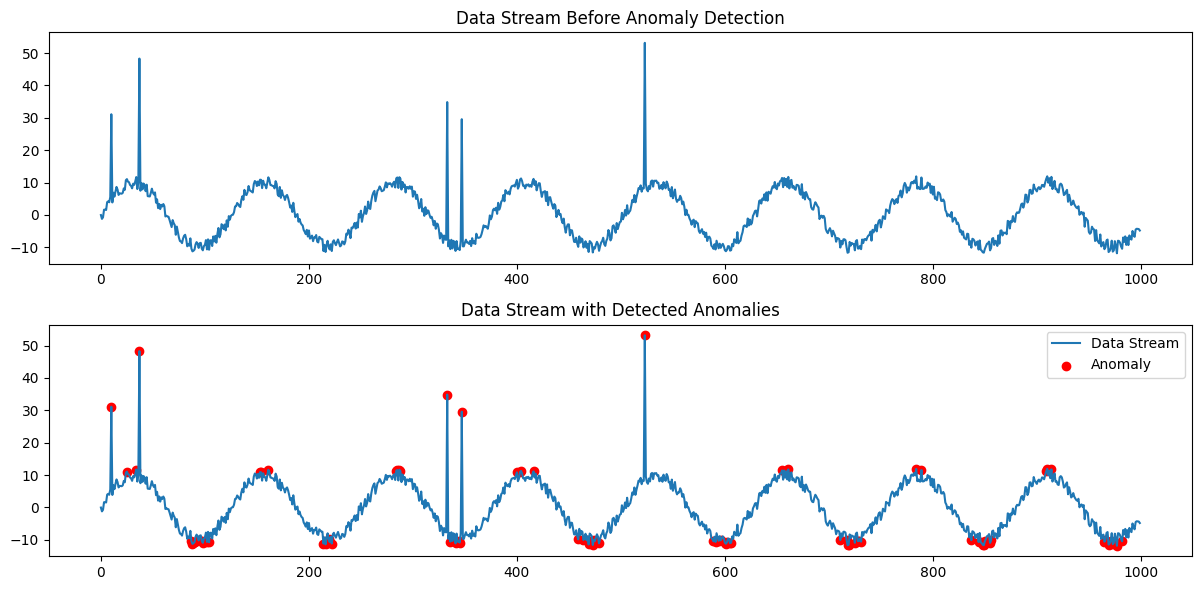

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

# Randomly partitioning the data for Isolation Tree
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.n_nodes = 0
        self.root = None

    def fit(self, data, current_height=0):
        if len(data) <= 1 or current_height >= self.height_limit:
            return None  # End recursion if max height reached or 1 data point
        self.n_nodes += 1
        # Select random feature and split threshold
        q = np.random.randint(0, data.shape[1])  # Random feature
        min_val, max_val = data[:, q].min(), data[:, q].max()
        if min_val == max_val:
            return None  # Stop splitting if all values are the same
        p = random.uniform(min_val, max_val)  # Random threshold
        left_data = data[data[:, q] < p]
        right_data = data[data[:, q] >= p]
        return {
            'split_feature': q,
            'split_value': p,
            'left': self.fit(left_data, current_height + 1),
            'right': self.fit(right_data, current_height + 1)
        }

    def path_length(self, x, tree, current_height=0):
        if tree is None:
            return current_height
        q = tree['split_feature']
        if x[q] < tree['split_value']:
            return self.path_length(x, tree['left'], current_height + 1)
        else:
            return self.path_length(x, tree['right'], current_height + 1)

# Isolation Forest model
class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []

    def fit(self, X):
        height_limit = math.ceil(math.log2(self.sample_size))
        for _ in range(self.n_trees):
            # Sample random subset of data
            sample_indices = np.random.choice(len(X), self.sample_size, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(height_limit)
            tree.root = tree.fit(X_sample)
            self.trees.append(tree)

    def anomaly_score(self, X):
        c = 2 * (math.log(self.sample_size - 1) + 0.5772156649) - (2 * (self.sample_size - 1) / self.sample_size)
        scores = []
        for x in X:
            path_lengths = [tree.path_length(x, tree.root) for tree in self.trees]
            avg_path_length = np.mean(path_lengths)
            scores.append(2 ** (-avg_path_length / c))  # Anomaly score calculation
        return np.array(scores)

# Function to generate synthetic data stream
def generate_synthetic_data_stream(n_samples=1000):
    t = 0
    data = []
    while len(data) < n_samples:
        seasonal_pattern = 10 * np.sin(t / 20)
        noise = random.uniform(-2, 2)  # Random noise
        value = seasonal_pattern + noise
        if random.random() > 0.99:
            value += random.uniform(20, 50)  # Anomalous value
        data.append(value)
        t += 1
    return np.array(data).reshape(-1, 1)

# Generate synthetic data
data_stream = generate_synthetic_data_stream(n_samples=1000)

# Fit Isolation Forest
iso_forest = IsolationForest(n_trees=100, sample_size=256)
iso_forest.fit(data_stream)

# Get anomaly scores
scores = iso_forest.anomaly_score(data_stream)

# Mark anomalies
threshold = 0.6  # can tune this threshold based on the data
anomalies = scores > threshold

# Plotting
plt.figure(figsize=(12, 6))

# Plot before detection (raw data)
plt.subplot(2, 1, 1)
plt.plot(data_stream, label="Data Stream")
plt.title("Data Stream Before Anomaly Detection")
plt.grid(False)

# Plot after detection (marking anomalies)
plt.subplot(2, 1, 2)
plt.plot(data_stream, label="Data Stream")
plt.scatter(np.arange(len(data_stream))[anomalies], data_stream[anomalies], color='r', label="Anomaly")
plt.title("Data Stream with Detected Anomalies")
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()
